# 팀프로젝트 Week1 ‒원티드 국민연금DB를 이용해서 유니콘 기업 발굴하기

데이터를 조인하면 회사의 국민연금고지금액, 매출액, 인원수를 월별로 볼 수 있습니다.       
유니콘기업으로 보이는 기업들을 나름의 방식으로 찾아주세요.        


**데이터정보**

- 회사수: 약5,000개
- 연도 : 2015 ~ 2019
- 월별데이터: 직원수, 국민연금보험료(인원 수에 대한 상한선_최대고지금액이 존재함)
- 년단위데이터: 매출액(천 원 단위)


**EDA 목표**

- 위 데이터들의 분포(직원수, 매출액, 보험료, +@)
- 몇몇 회사를 선택하여 데이터 흐름 살펴보기
- 데이터 사이의 관계에 대해 유의미한 결론을 찾아봅시다. (아이디어 수립==>EDA를 통해 관찰)



### 유니콘 기업 정의
**[유니콘 기업(Unicorn)은 기업 가치가 10억 달러(=1조 원) 이상이고 창업한 지 10년 이하인 비상장 스타트업 기업을 말한다.](https://ko.wikipedia.org/wiki/%EC%9C%A0%EB%8B%88%EC%BD%98_%EA%B8%B0%EC%97%85)**      


[캐치가 선정한 매출액 Top10 스타트업](https://m.catch.co.kr/Comp/CompThemeRank?TCode=163)
- 우아한 형제들
    - 매출액 : 1625억
    - 직원수 : 1050명(2020)
    
- 쏘카 
    - 매출액 : 1210억
    - 직원수 : 330명(2020)
    
- 네시삼십삼분
    - 매출액 : 722억 
    - 직원수 : 133명
    
- 딜리버리히어로코리아
    - 매출액 : 671억
    - 직원수 : 800명(2019)
    
- 리디 
    - 매출액 : 665억
    - 직원수 : 137명(2018)
    
- 야놀자
    - 매출액 : 545억
    - 직원수 : 1000명(2019)

- 블랭크코퍼레이션
    - 매출액 : 478억
    - 직원수 : 205명(2020)

- 레진엔터테인먼트
    - 매출액 : 448억
    - 직원수 : 143명(2019)

- 미미박스
    - 매출액 : 440억
    - 직원수 : 98명

- 뱅크웨어글로벌
    - 매출액 : 388억
    - 직원수 : 285명(2016)

  
#### 매출액 평균 : 719.2억 (최소 388억)       
#### 직원수 평균 : 418.1명 (최소 98명)     

# 최종 요약

1. 데이터 내 직원수가 0명인 회사를 제거한다.
2. 데이터 개수가 24개 이하인 회사를 제거한다. (업력 2년 이상)
3. 연매출액 700억 이하인 회사ID를 제거한다. (캐치 참고)
4. 직원수가 400명 이하인 회사ID를 제거한다. (캐치 참고)
5. 연매출액_변화량, 월별_직원수_변화량 컬럼을 생성한다.
6. 연매출액이 100억 이상 증가한 회사 ID만을 추출한다.
7. 직원수가 30명 이상 증가한 회사 ID만 추출한다.
7. 시각화 진행한다.



In [1]:
# 라이브러리 임포트
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys

import warnings
warnings.filterwarnings('ignore')

print("파이썬 버전 :",sys.version)
print("판다스 버전 :",pd.__version__)

파이썬 버전 : 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
판다스 버전 : 1.1.3


In [2]:
# 데이터 확인
path = "C:/Users/parkgun/Desktop/프리온보딩/팀프로젝트_1주차/data"
os.listdir(path)

# 데이터 불러오기
df = pd.read_csv(path+"/company_nps_data.csv", encoding="cp949")
display(df.head())

,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수
0,233757,41688077,2018,7,8912380,36
1,123464,1760695,2018,3,942380,5
2,342124,3221341,2018,7,781180,4
3,386420,4815584,2015,11,3795900,14
4,129243,9799736,2018,10,40724680,151


In [3]:
# 연도와 월을 묶어서 컬럼 형성
df['년월'] = pd.to_datetime(df['년도'].astype(str) + df['월'].astype(str), format='%Y%m').dt.strftime('%Y%m')

# 회사ID, 연도와 월을 제거해보자
df.drop(df[['년도','월']], axis=1, inplace=True)

# 시간순으로 나열해보자
df= df.sort_values(by='년월')

In [4]:
# 전체 파일 길이 
print("데이터 길이 :", len(df))

데이터 길이 : 99801


In [5]:
# 결측치 확인
df.isna().sum()

회사ID        0
연매출액        0
월별_연금보험료    0
월별_직원수      0
년월          0
dtype: int64

In [6]:
# 코드 참고 : https://github.com/chsop/team4_wanted_onboarding/blob/main/Jaehwan_onboarding_week1_EDA_v0.1.ipynb
# 월별 연금 보험료와 월별 직원수가 0인 경우 제외 처리
df = df.drop(index=df.query('월별_직원수 == 0').index)
print(df.shape)

(99788, 5)


In [7]:
# 데이터가 일정 개수 이상 존재하는 회사만 남긴다.
df = df.groupby("회사ID").filter(lambda x : len(x) > 24) # 업력이 2년 이상 ==> 모든 데이터가 연속인가?
print(df.shape)

(55358, 5)


In [8]:
# 연매출액 700억 이상 조건 적용
# 연 매출액 단위는 1000원 // 1조원 == 1000000000 // 1000억 == 100000000 // 100억원 == 10000000 // 

df = df[df['연매출액']>=70000000]
print(df.shape)

(3491, 5)


In [9]:
# 직원수 400명 이상 조건 적용

df = df[df['월별_직원수']>=400]
print(df.shape)

(978, 5)


In [10]:
# 연매출액과 직원수 변화량 컬럼을 만든다.

list_id = df['회사ID'].unique()
check_df = pd.DataFrame(columns= ['회사ID','연매출액','월별_연금보험료','월별_직원수','년월','연매출액_변화량','월별_직원수_변화량'])

for x in list_id :  
    new_df = df[df['회사ID']==x]
    change_sales_columns = [0]
    change_worker_columns = [0]
    for i in range(len(new_df)-1) :
        new_sales = new_df.iloc[i+1][1] - new_df.iloc[i][1]
        change_sales_columns.append(new_sales)
        new_worker = new_df.iloc[i+1][3] - new_df.iloc[i][3]
        change_worker_columns.append(new_worker)    
    new_df['연매출액_변화량'] = change_sales_columns
    new_df['월별_직원수_변화량'] = change_worker_columns
    check_df = pd.concat([check_df, new_df])

In [11]:
display(check_df)

,회사ID,연매출액,월별_연금보험료,월별_직원수,년월,연매출액_변화량,월별_직원수_변화량
28116,126814,421492545,116361880,504,201511,0,0
24210,126814,421492545,120877200,535,201512,0,31
1238,126814,399262755,119412840,531,201601,-22229790,-4
12005,126814,399262755,121694800,541,201602,0,10
61158,126814,399262755,118029320,513,201603,0,-28
...,...,...,...,...,...,...,...
99231,420008,1301747031,294177160,729,201812,0,-2
39174,294530,816918963,94923120,402,201810,0,0
90398,294530,816918963,98247920,417,201811,0,15
20227,294530,816918963,101092480,430,201812,0,13


In [12]:
# 연매출액과 직원수 변화가 없는 데이터를 제거한다.
check_id_list = check_df['회사ID'].unique()
print(check_id_list)

[126814 294387 294337 126521 294367 126538 439986 126674 126516 507086
 126664 403351 126983 227414 126606 126831 510329 227415 403359 403434
 469458 419998 126802 419945 419977 126772 403462 127065 469473 469677
 127090 127060 420046 420008 294530 403470]


In [13]:
# 연매출액 변화가 없는 회사 ID 제거
change_sales_list = []
for x in check_id_list :
    new_df = check_df[check_df['회사ID']==x]
    if sum(new_df['연매출액_변화량']) > 10000000 : # 연매출액 성장 100억 이상
        change_sales_list.append(x) 
print(len(change_sales_list), "개의 회사가 연매출액이 증가했습니다.")
print(change_sales_list)

# 직원수 변화가 없는 회사 ID 제거
change_worker_list = []
for z in change_sales_list :
    worker_df = check_df[check_df['회사ID']==z]
    if sum(worker_df['월별_직원수_변화량']) > 30 : # 직원수 30명 이상
        change_worker_list.append(z)   
print(len(change_worker_list), "개의 회사의 직원수가 증가했습니다.")  
print(change_worker_list)

20 개의 회사가 연매출액이 증가했습니다.
[126814, 294387, 294337, 294367, 126538, 126674, 126664, 126983, 227414, 126606, 126831, 227415, 403359, 403434, 469458, 126802, 419945, 403462, 469677, 420046]
12 개의 회사의 직원수가 증가했습니다.
[294387, 294337, 294367, 126538, 126664, 126983, 227414, 227415, 403359, 469458, 126802, 469677]


In [14]:
# 시각화 함수

def visualization(df,x) :
    new_name = df[df['회사ID']==x]
    print(x,"회사 그래프입니다.")
    plt.figure(figsize=(20,10))
    plt.subplot(221)
    plt.plot(new_name['년월'],new_name['연매출액'])
    plt.title("매출액", fontsize=25)
    plt.xticks(rotation='vertical')
    plt.subplot(222)
    plt.plot(new_name['년월'],new_name['월별_직원수'])
    plt.title("직원수", fontsize=25)
    plt.xticks(rotation='vertical')
    plt.show()
    print()
    print()

294387 회사 그래프입니다.


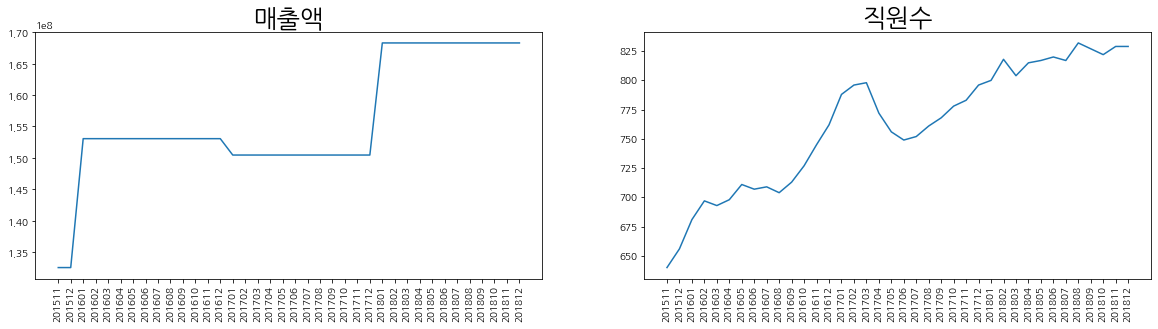



294337 회사 그래프입니다.


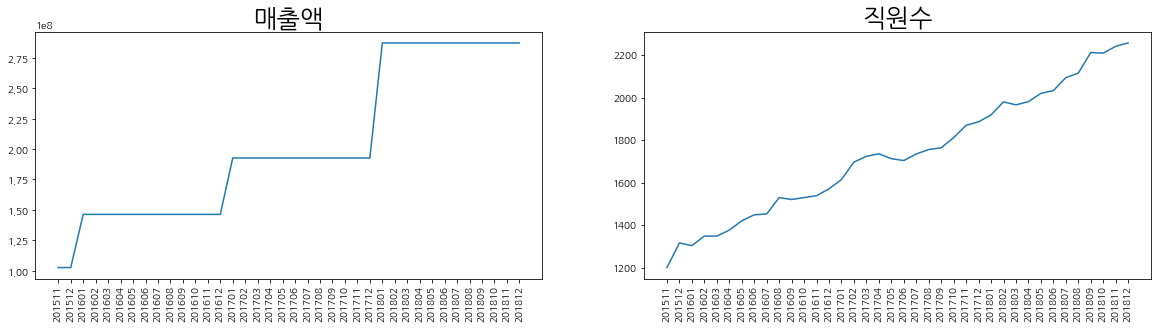



294367 회사 그래프입니다.


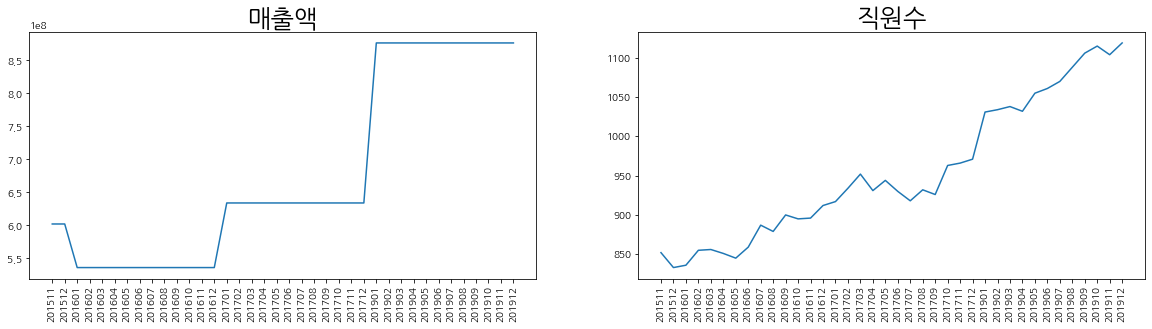



126538 회사 그래프입니다.


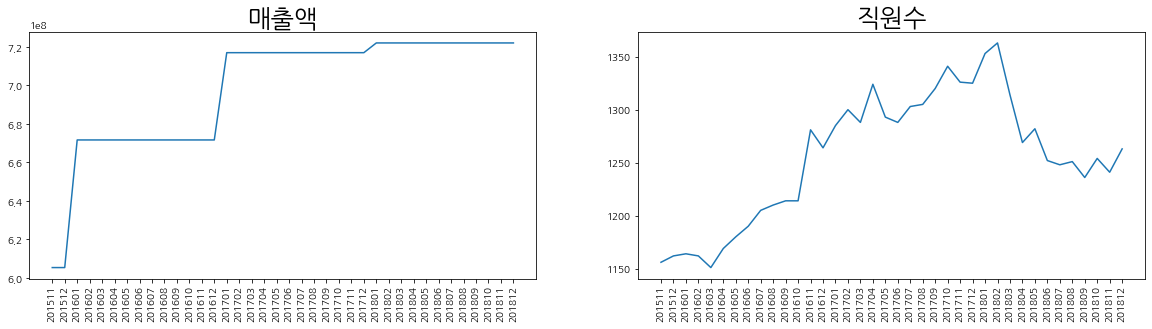



126664 회사 그래프입니다.


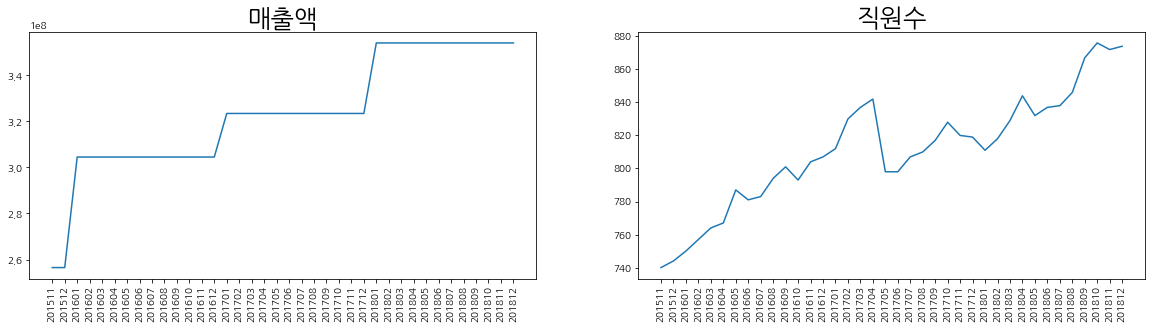



126983 회사 그래프입니다.


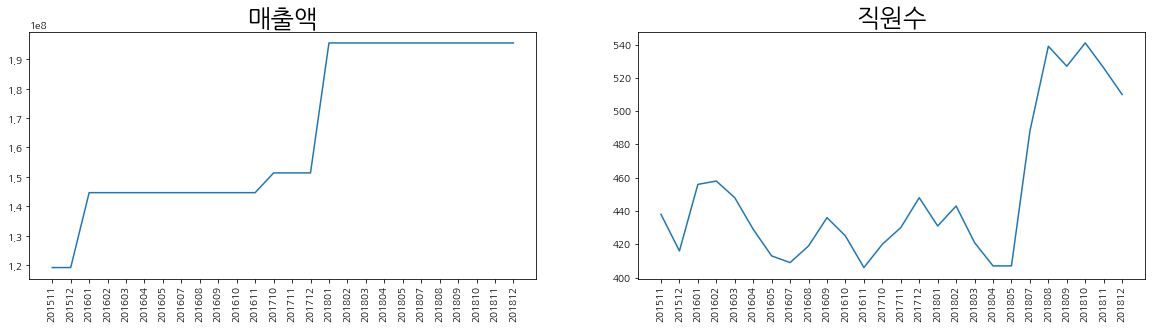



227414 회사 그래프입니다.


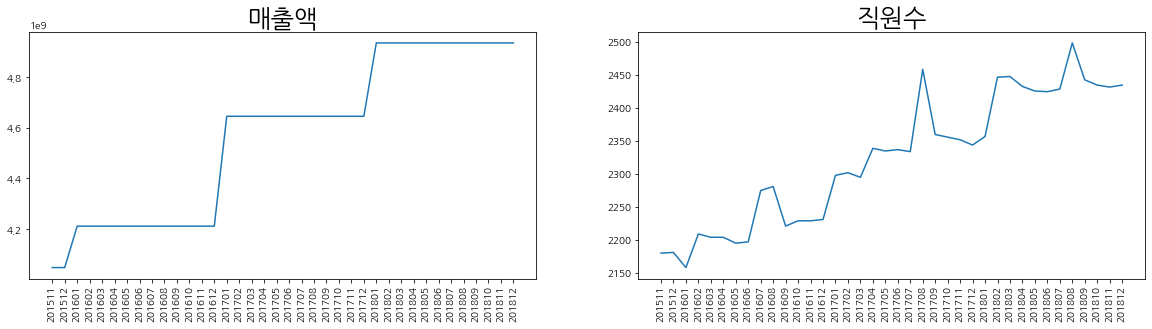



227415 회사 그래프입니다.


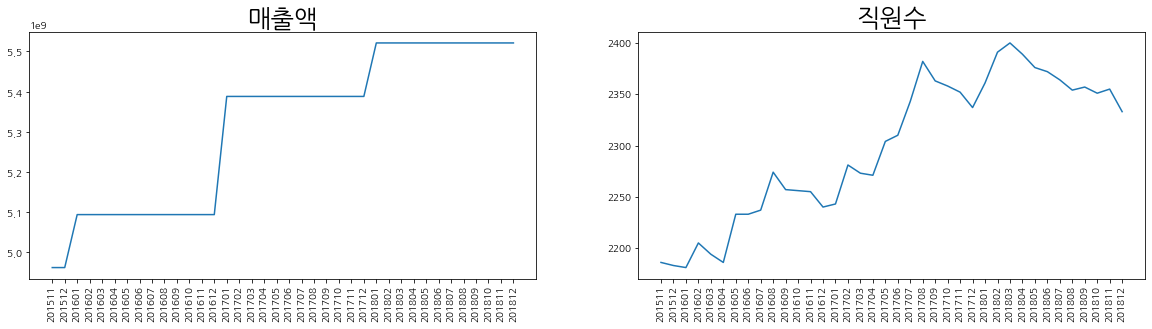



403359 회사 그래프입니다.


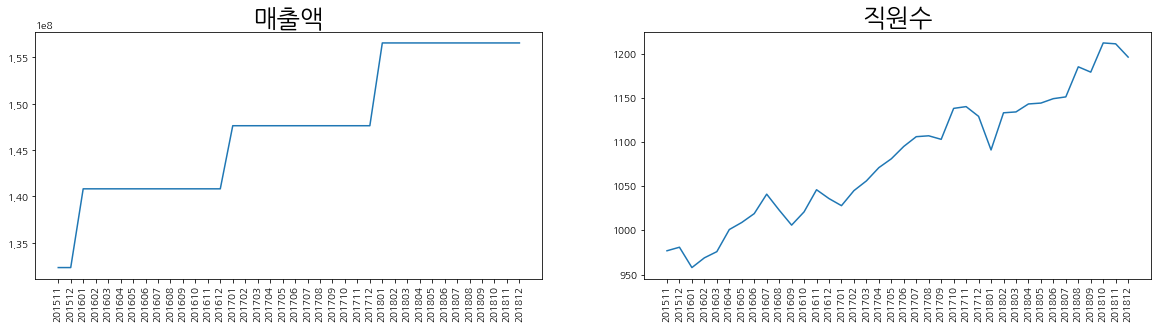



469458 회사 그래프입니다.


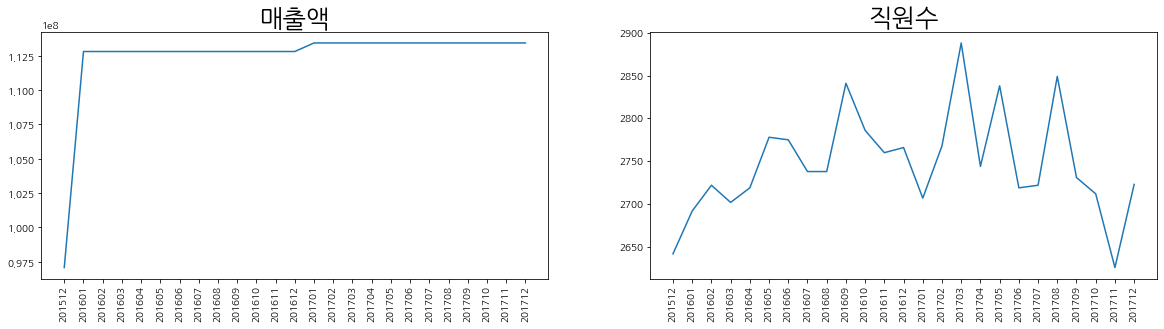



126802 회사 그래프입니다.


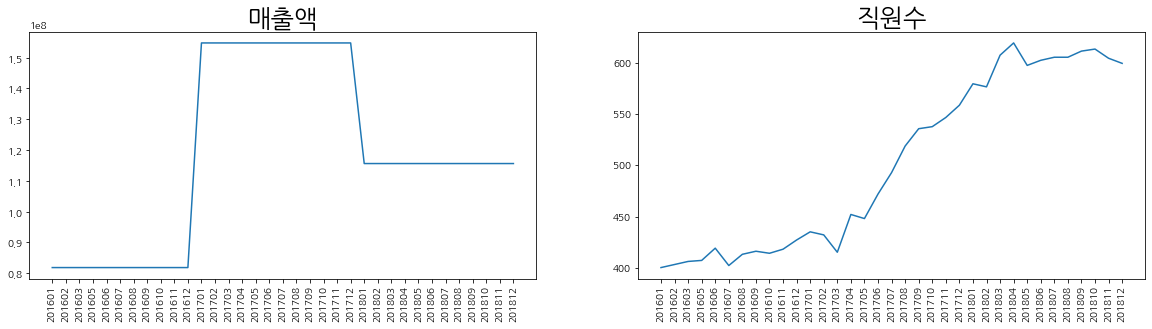



469677 회사 그래프입니다.


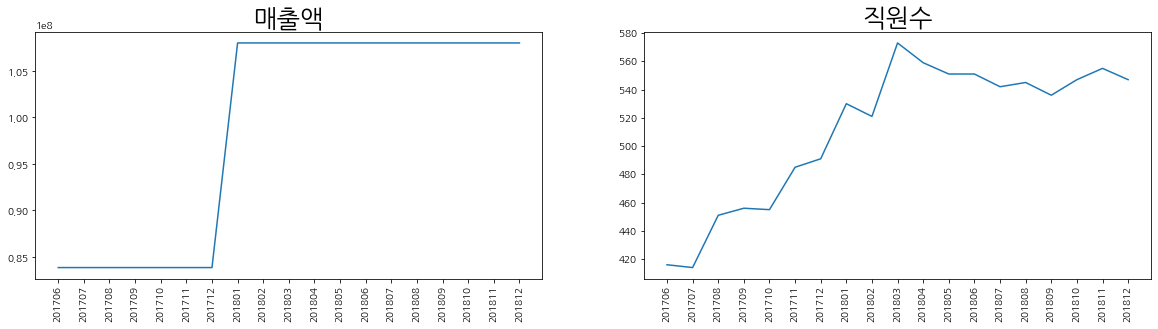

In [15]:
for x in change_worker_list :
    visualization(df,x)